In [3]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy.ndimage import gaussian_filter1d
import copy
import sys
sys.path.append('/home2/ebrahim/neural_seq_decoder/scripts/')
from load_data import map_from_channel_index_to_brain_area
from sklearn.decomposition import PCA
import pandas as pd
import scipy

In [5]:
load_non_smooth_data = True
if load_non_smooth_data:
    ba44 = np.load("/data/LLMs/willet/regression_data/ba44_nosmooth.npy")
else:
    ba44 = np.load('/data/LLMs/willet/regression_data/smooth_ba44_pow.npy')

In [6]:
def exponentially_weighted_average_2d(data, alpha):
    
    """
    Apply an exponentially weighted average filter to a 2D array (time x features).
    
    Parameters:
    - data: 2D numpy array of shape (time, features)
    - alpha: Smoothing factor (0 < alpha <= 1)
    
    Returns:
    - filtered_data: 2D numpy array of the filtered data
    """
    
    time, features = data.shape
    filtered_data = np.zeros_like(data)
    
    # Initialize the first value
    filtered_data[0, :] = data[0, :]
    
    # Apply the filter
    for t in range(1, time):
        filtered_data[t, :] = alpha * data[t, :] + (1 - alpha) * filtered_data[t - 1, :]
    
    return filtered_data

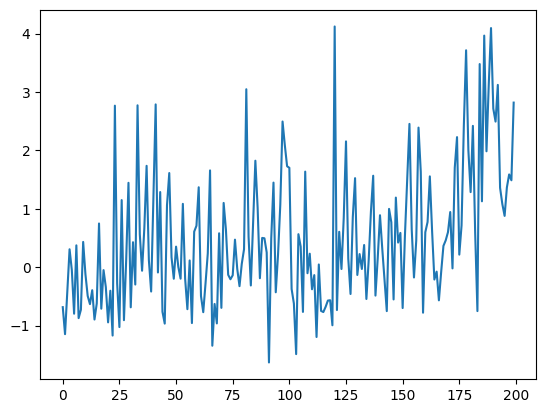

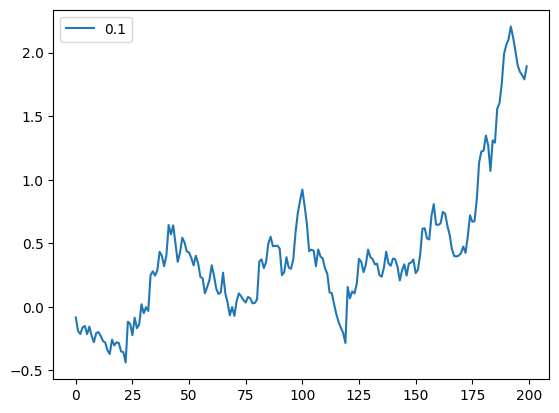

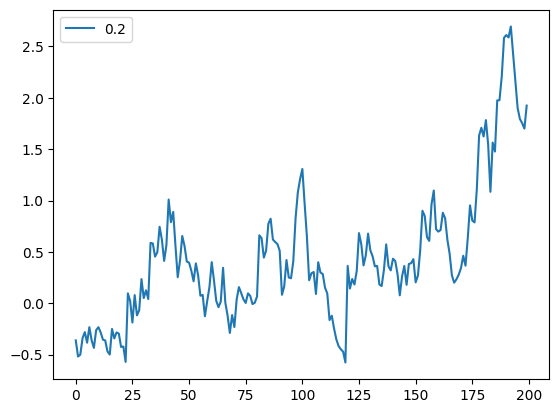

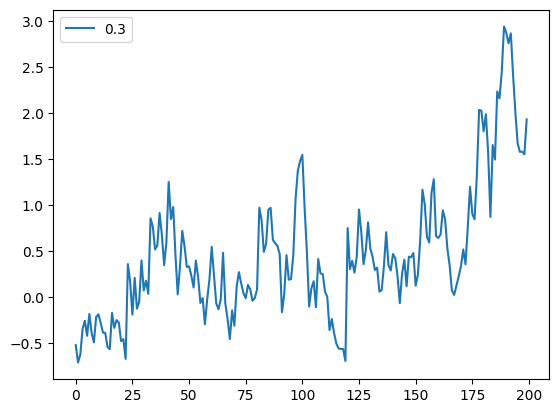

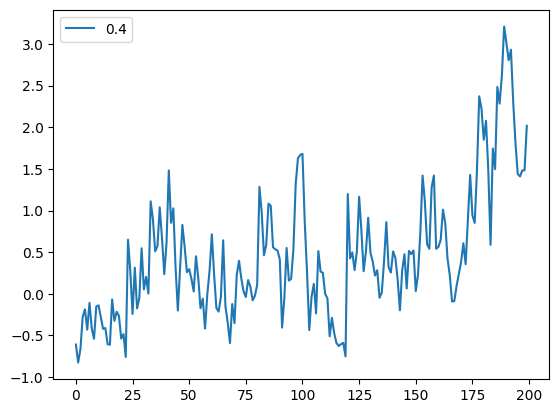

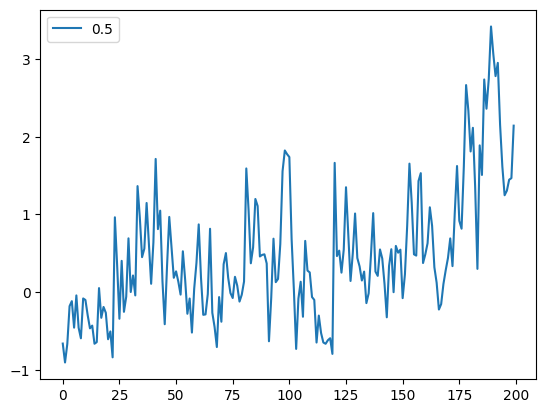

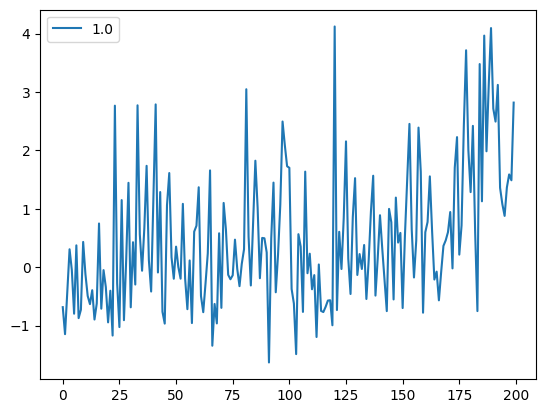

In [7]:
alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 1.0]

plt.plot(ba44[200:400, 0], label='0')
plt.show()
for a in alphas:
    ba44_alpha = exponentially_weighted_average_2d(ba44[:1000], alpha=a)
    plt.plot(ba44_alpha[200:400, 0], label=f"{a}")
    plt.legend()
    plt.show()

In [4]:
savePath = '/data/LLMs/willet/regression_data/'
dataFolder = '/data/LLMs/willet/regression_data'
block_sess = np.load('/data/LLMs/willet/block_sess.npy')
session = np.load('/data/LLMs/willet/session.npy')

In [45]:
val_sessions = np.load('/data/LLMs/willet/val_sess.npy')
val_mode = True
saveName = 'moving_avg'
alphas = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
alphas = [1e-4, 1e-3, 1e-2, 0.03]
alphas = [0.02, 0.04]

In [46]:
for a in alphas:
    
    print("Alpha values: ", a)    

    num_blocks = np.unique(block_sess).shape[0]

    ba44_smoothed = np.zeros_like(ba44)

    for i, bs in enumerate(np.unique(block_sess)):
        
        sess_selected = bs.split('_')[1]
        
        if val_mode:
            if sess_selected not in val_sessions:
                continue
            
        # indices corresponding to block and session 
        block_sess_idxs = np.argwhere(block_sess==bs).squeeze()
        
        # select ba44 data
        ba_44_neural_bs = ba44[block_sess_idxs]
        
        ba44_smoothed[block_sess_idxs] = exponentially_weighted_average_2d(ba_44_neural_bs, alpha=a)
        
    for sess in np.unique(session):

        if val_mode:
            if sess not in val_sessions:
                continue
        
        sess_idxs = np.argwhere(session==sess).squeeze()

        sess_data = ba44_smoothed[sess_idxs].squeeze()
        
        np.save(f'/data/LLMs/willet/regression_data/ba44_em_{a}_{sess}', sess_data)    

Alpha values:  0.02
Alpha values:  0.04


In [94]:
selected_alphas = [0.03]
delays = [[75,150]]
val_mode = False
concat_with_audio = True
go_audio= np.load('/data/LLMs/willet/regression_data/go_audio.npy')

In [97]:
for selected_alpha in selected_alphas:
    for d in delays:
        
        print(selected_alpha)
        
        print("Delay value: ", d) 

        num_blocks = np.unique(block_sess).shape[0]
        
        num_delays = len(d)

        ba44_delayed = np.zeros((ba44.shape[0], ba44.shape[1]*(1+num_delays)))

        for i, bs in enumerate(np.unique(block_sess)):
            
            sess_selected = bs.split('_')[1]
            
            if val_mode:
                if sess_selected not in val_sessions:
                    continue
                
            # indices corresponding to block and session 
            block_sess_idxs = np.argwhere(block_sess==bs).squeeze()
            
            # select ba44 data
            ba_44_neural_bs = ba44[block_sess_idxs]
            
            if selected_alpha != 1:
                ba_44_neural_bs = exponentially_weighted_average_2d(ba_44_neural_bs, alpha=selected_alpha)
            
            ba44_delayed[block_sess_idxs, :128] = ba_44_neural_bs
            delay_str = ''
            for i, delay_int in enumerate(d):
                delay_str += f'{delay_int}_'
                padding_amount = np.zeros((delay_int, ba44.shape[1]))
                ba44_delayed[block_sess_idxs, (i+1)*(128):(i+2)*128] = np.vstack((padding_amount, ba_44_neural_bs[:-delay_int]))
            
        for sess in np.unique(session):
            
            print(sess)
            if val_mode:
                if sess not in val_sessions:
                    continue
                
            sess_idxs = np.argwhere(session==sess).squeeze()

            sess_data = ba44_delayed[sess_idxs].squeeze()
            
            if concat_with_audio:
                
                audio_go_ba44 = np.hstack((go_audio[sess_idxs].squeeze(), sess_data))
            
                np.save(f'/data/LLMs/willet/regression_data/goaudio_ba44_alpha_{selected_alpha}_delay_{delay_str}{sess}', audio_go_ba44)    
                
            else:
                
                np.save(f'/data/LLMs/willet/regression_data/ba44_alpha_{selected_alpha}_delay_{delay_str}{sess}', sess_data)    
                

0.03
Delay value:  [75, 150]
04.28
05.05
05.17
05.19
05.24
05.26
06.02
06.07
06.14
06.16
06.21
06.23
06.28
07.05
07.14
07.21
07.27
07.29
08.02
08.11
08.13
08.18
08.23
08.25
